# Comparing survival curves

## Introduction

Survival analysis is more than just tracking mortality; it's about understanding the time until any defined event occurs, be it disease progression, mechanical failure, or even customer churn. In this chapter we delve into the powerful tools and techniques used to compare survival experiences, empowering us to discern crucial patterns and differences in time-to-event data.

From creating insightful visualizations of survival patterns with Kaplan-Meier curves to rigorously testing for differences using the log-rank test, and further exploring the complexities of survival data through both semi-parametric Cox PH models and parametric Weibull regression, the [lifelines library in Python](https://lifelines.readthedocs.io/en/stable/index.html) provides an accessible and powerful platform for conducting comprehensive survival analyses.

## Prednisolone case study

We'll apply the Kaplan-Meier method to a real-world dataset. Inspired by an example from [Intuitive Biostatistics 4th Edition book by Harvey Motulsky](https://global.oup.com/ushe/product/intuitive-biostatistics-9780190643560), we reanalyze the data from a prospective controlled trial of prednisolone therapy in hepatitis B surface antigen negative chronic active hepatitis, as discussed by [Altman and Bland](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1113717/). These patients were randomized into two distinct groups; one received treatment with *prednisolone* and the other received a placebo.

This example will serve as the bedrock for our exploration of advanced survival analysis techniques, including hazard ratio estimation and more.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

print('lifelines version:', lifelines.__version__)

lifelines version: 0.29.0


We first prepare the data by ensuring durations and censoring indicators are in the correct format. We simply enter the table from the original article manually into a DataFrame.

In [33]:
data = pd.DataFrame({
    'T': [  # Time in months
        2,3,4,7,10,22,28,29,32,37,40,41,54,61,63,71,127,140,146,158,167,182,           # control
        2,6,12,54,56,68,89,96,96,125,128,131,140,141,143,145,146,148,162,168,173,181,  # PRED
    ],
    'E': [
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,   # 1:death
        1,1,1,1,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,   # 0:censored
    ],
    'PRED': [False]*22 + [True]*22,  # encode the treatment group as True or False
})

In [34]:
data.head()

,T,E,PRED
0,2,1,False
1,3,1,False
2,4,1,False
3,7,1,False
4,10,1,False


### Handling dates in survival analysis

In real-world scenarios, survival data often involves dates rather than numeric durations. To accommodate this, we'll demonstrate how to convert dates into a format compatible with lifelines.

First, we ensure our dataset includes a censoring indicator. Here, we assume that non-null values in the 'Death' column represent events (deaths), while nulls indicate censoring:

```python
from datetime import datetime
import numpy as np

data['Censored'] = data['Death'].notnull().astype(np.int)
```

Next, we calculate durations in days from a reference date ('D0') for both events and censored observations:

```python
data['Days'] = np.where(
    data['Censored'] == 1,
    data['Death'] - data['D0'],
    datetime.now() - data['D0'])
```

For scenarios where we start with pure date strings, lifelines offers a convenient helper function:
```python
from lifelines.utils import datetimes_to_durations

start_date= ['2013-10-10 0:00:00', '2013-10-09', '2013-10-10']
end_date = ['2013-10-13', '2013-10-10', None]

T, E = datetimes_to_durations(
    start_date,
    end_date, 
    fill_date='2013-10-15') 
```

### Kaplan-Meier analysis

In the following code, we're performing a Kaplan-Meier survival analysis to visualize and compare the survival experiences of the two patient groups. We use the `KaplanMeierFitter` from the lifelines library to fit survival curves for each group and plot them on the same graph. We also customize the plot's appearance for clarity and visual appeal.

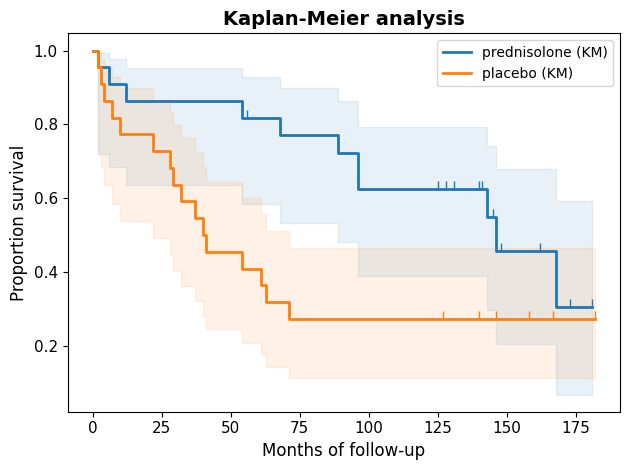

In [35]:
from lifelines import KaplanMeierFitter

kmf_ctrl = KaplanMeierFitter(label='placebo (KM)')
kmf_pred = KaplanMeierFitter(label='prednisolone (KM)')

# Define censor styles once for reuse
censor_styles = {'marker': 2, 'ms': 6}

# Filter data directly within the .fit() call
# Fit and plot for prednisolone group
kmf_pred.fit(
    durations=data.loc[data['PRED'], 'T'],
    event_observed=data.loc[data['PRED'], 'E'],
    # label='prednisolone (KM)',
)
ax = kmf_pred.plot_survival_function(
    show_censors=True,
    lw=2,
    ci_alpha=.1,
    censor_styles=censor_styles)

# Extract median survival times of the prednisolone group
median_survival_pred = kmf_pred.median_survival_time_


# Fit and plot for control placebo group on the same axes
kmf_ctrl.fit(data[~data['PRED']]['T'], data[~data['PRED']]['E'])
kmf_ctrl.plot_survival_function(
    ax=ax,
    show_censors=True,
    lw=2,
    ci_alpha=.1,
    censor_styles=censor_styles)

# Extract median survival times of the placebo group
median_survival_ctrl = kmf_ctrl.median_survival_time_

# Customize plot appearance
plt.xticks(fontsize=11)
plt.xlabel('Months of follow-up', fontdict={'size': 12})
plt.yticks(fontsize=11)
plt.ylabel('Proportion survival', fontdict={'size': 12})
plt.title(
    'Kaplan-Meier analysis',
    fontdict={'size': 14, 'weight': 'bold'})

plt.tight_layout();
# plt.savefig('survival.svg');
# It's also possible to generate a Plotly plot using the .mpl_to_plotly()
# method, see https://plot.ly/ipython-notebooks/survival-analysis-r-vs-python/

The Kaplan-Meier curves visually depict the survival experiences of the two groups. Both curves initially start at 100%, indicating that all patients are alive at the beginning of the study. However, they diverge notably over time. The separation between the curves, particularly during the initial months, strongly suggests that the treatment had a positive impact on survival.

### Beyond the curves

The Kaplan-Meier curves paint a visual story, but the `KaplanMeierFitter` object holds a treasure trove of insights beyond the plot. Let's delve deeper into its capabilities, extracting key metrics and making predictions to enhance our understanding of the survival patterns.

#### Median survival

The median survival time, the point at which 50% of the subjects have experienced the event (in this case, death), is a commonly used summary statistic in survival analysis. We can calculate the ratio of median survival times between the two groups to quantify the treatment's effect. Additionally, under the assumption of proportional hazards, we can estimate a 95% confidence interval for this ratio, providing a measure of uncertainty around our estimate.

In [36]:
print(f"Median survival time for prednisolone group: {median_survival_pred}")
print(f"Median survival time for control group: {median_survival_ctrl}")

Median survival time for prednisolone group: 146.0
Median survival time for control group: 40.0


#### Survival predictions

While median survival time is valuable, other statistics like mean time until death or five-year survival might not always be as informative in survival analysis. This is because these statistics can be heavily influenced by censoring, where some patients are lost to follow-up or the study ends before they experience the event.

Nevertheless, we can easily predict the survival probability at specific time points.

In [37]:
month=5*12  # 5-year survival
print(f"Survival prediction at month {month}:")
print(f"Group {kmf_ctrl._label}:\t{kmf_ctrl.predict(month):.1f}")
print(f"Group {kmf_pred._label}:{kmf_pred.predict(month):.1f}")

Survival prediction at month 60:
Group placebo (KM):	0.4
Group prednisolone (KM):0.8


#### Survival function

Provides the estimated probability of surviving beyond any given time point.

In [38]:
print(kmf_pred.survival_function_.head())  # Series returned

          prednisolone (KM)
timeline                   
0.0                1.000000
2.0                0.954545
6.0                0.909091
12.0               0.863636
54.0               0.818182


## Non-parametric log-rank test

### A little bit of theory

In survival analysis, **non-parametric** tests shine when we make no assumptions about the underlying shape of the survival curves. They offer flexibility, especially when the data doesn't neatly fit into predefined distributions. In contrast, **parametric** tests rely on specific distributional assumptions (e.g., Weibull, exponential) to model the survival data.

The log-rank test, also known as the **Mantel-Cox test**, evaluates the null hypothesis that there's *no difference in survival between two or more groups*: $S_A(t) = S_B(t) = \dots $. It essentially compares the observed number of events (e.g., deaths) in each group at each distinct event time to the number of events we would expect if there were no difference in survival between the groups. It then combines these comparisons across all event times to assess the overall evidence against the null hypothesis of equal survival. It's step-by-step breakdown can be summarized as follows:

1. Pooling the data: the log-rank test starts by pooling all the event times from all groups, creating a combined timeline of events.
2. Calculating expected events: at each event time on this combined timeline, the test calculates the expected number of events for each group. This is done under the null hypothesis that the survival curves are the same for all groups. The expected number of events for a group at a particular time point is based on:
   - The total number of individuals at risk (i.e., still alive and uncensored) at that time point across all groups.
   - The proportion of individuals at risk in that specific group at that time point.
   - The total number of events observed at that time point across all groups.
3. Comparing observed and expected: the test then compares the observed number of events in each group at each event time to the expected number of events. It quantifies the discrepancies between observed and expected events across all time points using a test statistic (often a **chi-squared statistic**).
4. Calculating the P value: the test statistic is used to calculate a P value, which represents the probability of observing a difference in survival as extreme as (or more extreme than) the one actually observed, if the null hypothesis were true (i.e., if there were no real difference in survival between the groups).
5. Interpreting the P value. The P value answers this question:
    > If the null hypothesis is true (i.e., there's no real difference in survival between the groups), what is the probability of observing a difference in survival as extreme as (or more extreme than) the one we actually observed, just by random chance?
   - A small P value (typically < 0.05) suggests that the observed difference in survival is unlikely to have occurred by chance alone, leading to the rejection of the null hypothesis. We conclude that there's a statistically significant difference in survival between the groups.
   - A large P value suggests that the observed difference could be due to chance, and we fail to reject the null hypothesis. We don't have enough evidence to conclude a significant difference in survival.

### Using log-rank test in Python

With `lifelines`, performing the log-rank test is straightforward using `logrank_test`. For multiple groups, consider `pairwise_logrank_test()` to perform all pairwise comparisons between groups, or `multivariate_logrank_test()` to test the overall hypothesis that all groups have the same survival.

In [39]:
from lifelines.statistics import logrank_test

# Perform the log-rank test
results = logrank_test(
    durations_A=data.loc[data['PRED'], 'T'],
    durations_B=data.loc[~data['PRED'],'T'],
    event_observed_A=data.loc[data['PRED'], 'E'],
    event_observed_B=data.loc[~data['PRED'],'E'],
    alpha=.95)

# Print the summary of the results
print(results.summary)

# results.print_summary()
# results.p_value
# results.test_statistic

   test_statistic         p  -log2(p)
0        4.659901  0.030875  5.017419


In the current example, the two-tailed P value calculated using the log-rank test is 0.031. This means that if the treatment were truly ineffective, there's only a 3.1% chance that we would have randomly selected patients whose survival experiences differed as much (or more) as they did in this study.

### Mantel-Haenszel method

Both log-rank (Mantel-Cox) and Manter-Haenszel are non-parametric methods used to compare survival curves between groups. They are very similar in their approach and often yield similar results. [The main difference lies in how they handle ties](https://www.graphpad.com/support/faq/how-do-the-three-methods-compare-to-survival-curves-log-rank-mantel-haenszel-gehan-wilcoxon-differ/) (multiple events occurring at the same time point). The Mantel-Haenszel test makes a slight adjustment for ties, while the log-rank test doesn't. In practice, the difference between the two tests is often negligible, especially with large sample sizes or few ties.

### Gehan-Breslow-Wilcoxon method

The [Gehan-Breslow-Wilcoxon test](https://www.graphpad.com/guides/prism/latest/statistics/stat_analysis_choices_for_survival.htm) emphasizes differences in survival occurring early in the study, which can be insightful in certain scenarios. However, this emphasis can be misleading if a large proportion of patients are censored early on (i.e., lost to follow-up or the study ends before their event occurs).

In contrast, the log-rank test treats all time points equally, making it more statistically powerful when the assumption of proportional hazards holds true. If the Kaplan-Meier curves for the two groups cross, this suggests non-proportional hazards, indicating that the relative risk changes over time. In such cases, alternative tests like the [Peto-Peto Prentice, Tarone-Ware, or Fleming-Harrington tests](https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html) might be more appropriate.

In [40]:
# Using the Gehan-Breslow-Wilcoxon method
results_wilcoxon = logrank_test(
    durations_A=data.loc[data['PRED'], 'T'],
    durations_B=data.loc[~data['PRED'], 'T'],
    event_observed_A=data.loc[data['PRED'], 'E'],
    event_observed_B=data.loc[~data['PRED'], 'E'],
    alpha=.95,
    weightings='wilcoxon')

results_wilcoxon.print_summary()

<lifelines.StatisticalResult: Wilcoxon_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = Wilcoxon_test

---
 test_statistic    p  -log2(p)
           6.54 0.01      6.57

## Hazard ratio for quantifying relative risk

While Kaplan-Meier curves offer a powerful visual representation of survival experiences, they don't directly reveal the underlying dynamics of risk over time. To gain insights into the instantaneous risk of an event at any given moment, we turn to the **hazard function**, denoted by $h(t)$.

In survival analysis, the **hazard** represents the instantaneous **risk** of experiencing the event of interest (e.g., death) at a given time, given that the individual has survived up to that point. Think of it as the "slope" of the survival curve - a steeper slope indicates a higher hazard, meaning events are occurring more rapidly.

The **hazard ratio (HR)** compares the hazards of two groups, providing a measure of relative risk. If the HR is 2.0, it signifies that the rate of events in one group is twice the rate in the other group at any given time point. In simpler terms, individuals in the first group are experiencing the event at twice the speed of those in the second group.

The interpretation of the hazard ratio hinges on the **assumption of proportional hazards**. This assumption states that the *hazard ratio remains constant over time*, regardless of their covariate values. Mathematically: $h_A(t) / h_B(t) = c$, where $h_A(t)$ and $h_B(t)$ are the hazard functions of the treatment groups, and $c$ is a constant.

In other words, the relative risk between the two groups stays the same throughout the follow-up period. If this assumption holds, we can confidently say that, for example, patients in one treatment group are consistently experiencing the event at half the rate of patients in the other group, regardless of how much time has passed.

However, the proportional hazards assumption isn't always met in real-world scenarios. Consider the comparison between surgery and medical therapy. Surgery often carries a higher initial risk, but the risk may decrease over time as patients recover. In contrast, medical therapy might have a lower initial risk, but the risk could increase as the disease progresses. In such cases, the hazard ratio wouldn't be constant, violating the proportional hazards assumption.

### Unveiling hazards with the Nelson-Aalen estimator

#### The mathematics behind the model

We can't simply transform the Kaplan-Meier estimate to obtain the hazard function because statistical intricacies prevent such a straightforward conversion. But we have a robust *non-parametric* tool at our disposal: the Nelson-Aalen estimator. This estimator allows us to estimate the **cumulative hazard function**, $H(t)$, which represents the total accumulated risk of experiencing the event up to time $t$.

Mathematically, the cumulative hazard is defined as the integral of the hazard function: $H(t) = \int_{0}^t \lambda(z)dz$, where $\lambda(z)$ represents the hazard function at time $z$.

The Nelson-Aalen estimator provides a practical way to estimate $H(t)$ from observed data: $\hat{H}(t) = \sum_{t_i \le t} \frac{d_i}{n_i}$. In this formula:

- $\hat{H}(t)$ is the estimated cumulative hazard at time $t$.
- The summation is over all event times ($t_i$) that are less than or equal to $t$.
- $d_i$ is the number of events (e.g., deaths) observed at time $t_i$
- $n_i$ is the number of individuals at risk (i.e., still alive and uncensored) just before time $t_i$

#### Using the `NelsonAalenFitter`

Let's generate a plot showing the cumulative hazard estimates for both the treatment 'PRED' and control groups, allowing us to visualize and compare the accumulation of risk over time between the two.

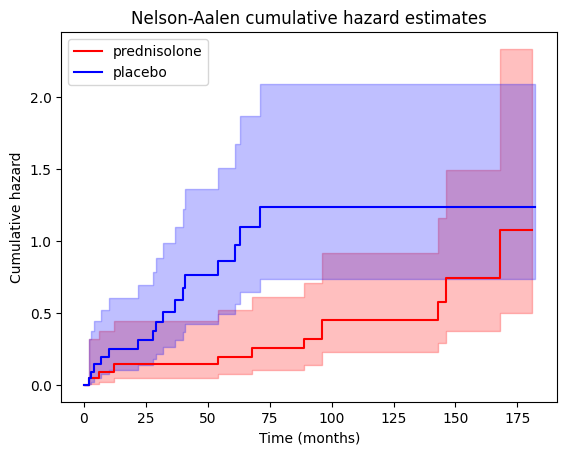

In [41]:
from lifelines import NelsonAalenFitter

naf_pred = NelsonAalenFitter()
naf_ctrl = NelsonAalenFitter()

# Fit Nelson-Aalen estimators for each group
naf_pred.fit(
    data[data['PRED']]['T'],
    event_observed=data[data['PRED']]['E'],
    label='prednisolone')
naf_ctrl.fit(
    data[~data['PRED']]['T'],
    event_observed=data[~data['PRED']]['E'],
    label='placebo')

# Plot cumulative hazard functions
ax = plt.subplot(111)
naf_pred.plot(ax=ax, color='red')
naf_ctrl.plot(ax=ax, color='blue')

# Customize plot appearance
plt.xlabel('Time (months)')
plt.ylabel('Cumulative hazard')
plt.title('Nelson-Aalen cumulative hazard estimates');

We can also access the cumulative hazard data through the `cumulative_hazard_` attribute of the `NelsonAalenFitter` objects.

In [42]:
# Print cumulative hazard data (top 5) for PRED group
print("\nCumulative Hazard Data for PRED group:\n")
print(naf_pred.cumulative_hazard_.head())


Cumulative Hazard Data for PRED group:

          prednisolone
timeline              
0.0           0.000000
2.0           0.045455
6.0           0.093074
12.0          0.143074
54.0          0.195705


#### Connection to Kaplan-Meier survival

There is a fundamental mathematical relationship between Kaplan-Meier survival curves and Nelson-Aalen cumulative hazard estimates, which can be thought of as a form of symmetry or duality: $S(t) = \exp[-H(t)]$, where
- $S(t)$ is the survival function at time $t$ (estimated by the Kaplan-Meier method)
- $H(t)$ is the cumulative hazard function at time $t$ (estimated by the Nelson-Aalen method)

This equation shows that the survival probability at any time point is directly related to the cumulative hazard up to that point. This relationship has other implications:
- Complementary information: the Kaplan-Meier curve and the Nelson-Aalen plot provide complementary perspectives on the same underlying survival data.
- Shape correspondence:
  - A decreasing Kaplan-Meier curve (indicating decreasing survival probability) corresponds to an increasing Nelson-Aalen curve (indicating accumulating hazard).
  - The steeper the drop in the Kaplan-Meier curve, the steeper the rise in the Nelson-Aalen curve, reflecting a higher hazard rate at that time.
- Transformation: we can mathematically transform one into the other. If we have the Kaplan-Meier estimate, we can calculate the cumulative hazard as $H(t) = -\log[S(t)]$. Conversely, if we have the Nelson-Aalen estimate, we can calculate the survival function as $S(t) = \exp[-H(t)]$.
- If we plot the Kaplan-Meier curve and the Nelson-Aalen curve on the same graph (with appropriate scaling of the y-axes), we'll often observe a *visual symmetry* or mirror-image relationship between the two. This visual correspondence reflects the underlying mathematical connection between survival probability and cumulative hazard.

#### The link with hazard ratio

While the Nelson-Aalen estimator directly estimates the cumulative hazard function, it doesn't provide a *hazard ratio* in the same way that a Cox proportional hazards model does. However, it's still connected to the concept of hazard ratios in a few key ways:

1. Visual assessment of proportional hazards
   - The Nelson-Aalen plots for two or more groups can visually suggest whether the proportional hazards assumption might hold. If the curves are *roughly parallel* (i.e., maintain a relatively constant vertical distance), it hints at proportional hazards. Conversely, if the curves cross or diverge significantly, it suggests non-proportional hazards.
   - This visual assessment can guide us in deciding whether a Cox model (which assumes proportional hazards) is appropriate for further analysis.
2. Estimating hazard ratios (with caution)
   - Although not directly, we can crudely estimate hazard ratios from Nelson-Aalen plots by comparing the slopes of the cumulative hazard curves at different time points. A steeper slope indicates a higher hazard rate.
   - However, this approach is less precise and less reliable than the hazard ratios obtained from a Cox model, especially when the proportional hazards assumption is violated.
3. Basis for Cox model diagnostics
   - The Nelson-Aalen estimator plays a crucial role in diagnosing the proportional hazards assumption in Cox models.
   - One common diagnostic plot involves plotting the log of the Nelson-Aalen cumulative hazard estimates against the log of survival time for each group. If the proportional hazards assumption holds, these plots should be roughly parallel.

### Cox proportional hazards model

While the [Weibull model (discussed later)](weibull) is a popular parametric choice for survival analysis, sometimes its distributional assumptions might not be met or are difficult to verify. In such cases, researchers often turn to the **Cox proportional hazards (Cox PH) model**, a *semi-parametric approach* that offers flexibility while still allowing for the inclusion of **covariates**.

The Cox model expresses the hazard function as $h(t|x) = h_0(t) * \exp[(x - \overline{x})' \beta]$, where:
- $h(t|x)$ is the hazard at time $t$ for an individual with covariate values $x$.
- $h_0(t)$ is the baseline hazard, representing the hazard when all covariates are at their average values ($\overline{x}$).
- $x$ is the vector of covariate values for the individual.
- $(x - \overline{x})'$ is the transpose (row vector) of $(x - \overline{x})$, which explicitly shows the deviation of the individual's covariate values from the average values, and then multiplies this deviation with the coefficient vector.
- $\beta$ is the vector of coefficients, quantifying the impact of each covariate on the hazard.

The hazard function, $h(t)$, describes the instantaneous risk of the event occurring at time $t$, given that the individual has survived up to that point. Mathematically, it's related to the survival function, $S(t)$, as follows $h(t) = - \frac{d}{dt} \log S(t)$.

A simplified representation of the Cox model is: $h(t)=h_0(t) \times \exp(b_1 x_1 + b_2 x_2 + ... + b_p x_p)$, where:
- $t$ represents the survival time
- $h(t)$ is the hazard function. *The $t$ in $h(t)$ reminds us that the hazard may vary over time.*
- $x_1, x_2, \dots, x_p$ are the covariates.
- $b_1, b_2, \dots, b_p$ are the coefficients representing the effect of each covariate on the hazard.
- $h_0$ is called the *baseline hazard*. It corresponds to the value of the hazard if all the $x_i$ are equal to zero, with $\exp(0) = 1$.

The coefficients ($b_i$) indicate how each covariate influences the hazard, e.g., a positive coefficient implies that an increase in the covariate value is associated with an increased hazard (and thus a decreased survival probability).

We can therefore appreciate the advantages of the Cox Model:
- Semi-parametric: it doesn't require assumptions about the shape of the baseline hazard function.
- Handles covariates: it allows for the inclusion of multiple covariates (both categorical and continuous) to adjust for their effects on survival.
- Provides hazard ratios: it directly estimates hazard ratios, which are easily interpretable measures of relative risk.

The expression $h(t|x) = b_0(t) \exp[\sum_{i=1}^n (b_i * x_i)]$ is another way to represent the Cox proportional hazards model, although it has a few subtle differences and potential points of confusion compared to the more standard notation. It uses $\sum_{i=1}^n (b_i * x_i)$ which directly calculates the linear combination of covariates and their coefficients without explicitly showing the deviation from the average.

#### Interpreting the Cox PH model

The summary of the Cox proportional hazards model typically includes the following key components for each covariate:
- **coef**: this represents the estimated coefficient ($\beta$) for the covariate in the Cox model.
- **exp(coef)**: this is the exponentiated coefficient, which represents the **hazard ratio** associated with a one-unit increase in the covariate, holding all other covariates constant.
  - If 'exp(coef)' > 1: a one-unit increase in the covariate is associated with an increased hazard (i.e., a higher risk of the event occurring) by a factor of 'exp(coef)' compared to the baseline hazard.
  - If 'exp(coef)' < 1: a one-unit increase in the covariate is associated with a decreased hazard (i.e., a lower risk of the event occurring) by a factor of '1/exp(coef)' compared to the baseline hazard.
- **p-value**: this indicates the statistical significance of the covariate's effect on the hazard. A small P value (typically < 0.05) suggests that the covariate is a significant predictor of survival.

In [43]:
from lifelines import CoxPHFitter

# Fit the CoxPHFitter
cph = CoxPHFitter()
cph.fit(df=data, duration_col="T", event_col="E", formula='PRED')

# Print the summary to see the coefficient and its significance
cph.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 44 total observations, 17 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 44
number of events observed = 27
   partial log-likelihood = -86.620
         time fit was run = 2024-11-08 09:30:08 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
PRED      -0.831     0.436     0.397          -1.609          -0.052               0.200               0.949

           cmp to      z     p  -log2(p)
covariate                               
PRED        0.000 -2.091 0.037     4.773
---
Concordance = 0.633
Partial AIC = 175.239
log-likelihood ratio test = 4.471 on 1 df
-log2(p) of ll-ratio test = 4.859

In this example, the hazard ratio equals 0.436, with a 95% confidence interval ranging from 0.200 to 0.949. This indicates that, at any given time, individuals in the treated group (`'PRED' = True`) have a hazard rate that is approximately 43.6% of the hazard rate in the control/reference group (`'PRED' = False`), assuming the proportional hazards assumption holds. In simpler terms, this suggests that treated patients are experiencing death at a significantly lower rate than control patients throughout the follow-up period.

Moreover, the 95% confidence interval for the HR does not include 1.0. This indicates that we can be 95% confident that the true hazard ratio in the population is not 1.0, i.e., the hazards are not equal between the two groups. This provides evidence for a statistically significant difference in survival experiences between the treated and control groups.
If the two survival curves were truly identical, the hazard ratio would indeed be 1.0. The fact that our confidence interval excludes 1.0 strengthens our conclusion that the treatment likely has a real effect on survival.

#### Assessing the proportional hazards assumption

To ensure the validity of our model and the accuracy of these interpretations, it's essential to check whether the proportional hazards assumption is reasonably met. The `lifelines` library provides a convenient method, [`check_assumptions()`](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html), to assist in this assessment. 


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


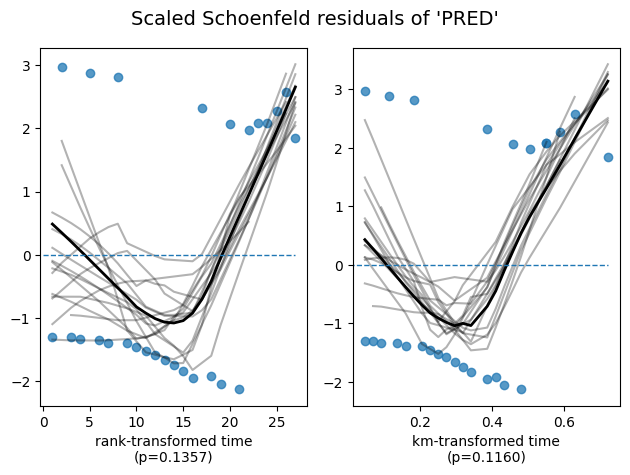

In [44]:
cph.check_assumptions(
    training_df=data,
    p_value_threshold=.05,  # default 0.01
    show_plots=True);

#### Visualizing the impact of covariate on survival

The Cox PH model allows us to estimate the effect of each covariate on the hazard rate. But how does this translate into actual changes in survival probabilities? The `plot_partial_effects_on_outcome` function provides a visual answer.

This function generates a plot showing the predicted survival curves for different values of a specific covariate ('PRED' in our case), while holding all other covariates (if any) constant at their average (or other specified) values. In essence, it lets us see how changing the value of 'PRED' would impact the survival experience, assuming everything else remains the same.

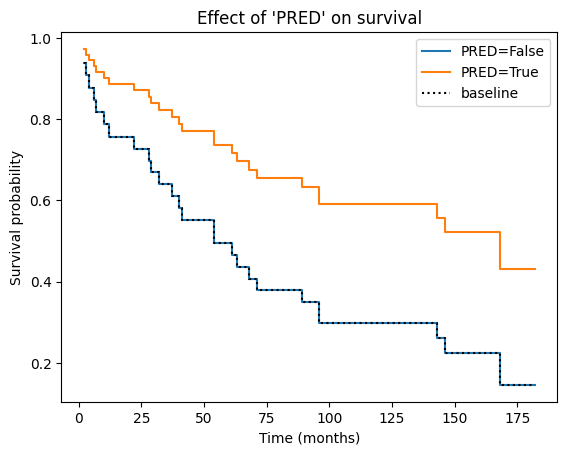

In [45]:
# Visualize the effect of the predictor on survival curves
cph.plot_partial_effects_on_outcome(
    covariates='PRED',
    values=[False, True],
    plot_baseline=True,
)
plt.title("Effect of 'PRED' on survival")
plt.xlabel('Time (months)')
plt.ylabel('Survival probability');

In the context of a Cox PH plot, the **baseline curve** represents the estimated survival function when all covariates in the model are set to their baseline or reference levels. The specific baseline level for each covariate depends on how it is coded in the model:
- Continuous covariates: the baseline level is typically the *mean or median* value of the covariate in the dataset.
- Categorical covariates: the baseline level is usually the *reference category* (e.g., the "control" group or the most common category).

_It's important to note that in the current version of `lifelines`, when dealing with categorical covariates, the reference or control group used for establishing the baseline is determined by the **first category encountered in the dataset** when the model is fit. In our case, since the first patient in the dataset has `PRED = False`, the baseline hazard and survival functions represent the untreated or control group. If 'PRED' were encoded numerically as 0 and 1, then 0 (representing the absence of prednisone treatment) would naturally become the baseline. Similarly, if the very first patient in the dataset had been assigned `PRED = True`, then the baseline would correspond to the prednisone-treated group._

This enhanced explanation provides a more accurate and nuanced understanding of how `lifelines` handles baseline selection for categorical covariates, which is crucial for interpreting the model results correctly. 

_Of note, in the current version of `lifelines`, the reference/control group chosen for the baseline is the first category of the dataset, i.e., `PRED = False`. If 'PRED' were encoded as 0 and 1, then 0 would be the baseline. If the very patient of the dataset was set as `PRED = True`, then the baseline would be the prednisone group._

Essentially, the baseline curve shows the survival experience we would expect for an "average" individual or an individual belonging to the reference categories of all categorical covariates, assuming the proportional hazards assumption holds.

Why do the curves from both groups have the same shape? This is a direct consequence of the proportional hazards assumption, which is the core principle underlying the Cox PH model. The proportional hazards assumption states that the hazard ratio between any two individuals remains constant over time, regardless of their covariate values.

Mathematically, this means that the hazard function for one group is simply a *constant multiple of the hazard function for another group*. When plotting the survival curves, this constant proportionality translates into curves that have the same basic shape but are vertically shifted relative to each other. The vertical shift reflects the difference in hazard (and thus survival probability) between the groups due to their different covariate values.

(weibull)=
## The Weibull parametric model

Having explored non-parametric and semi-parametric approaches, let's now turn our attention to a fully **parametric** model for survival analysis. The Weibull model is a popular parametric model in survival analysis due to its flexibility in capturing various hazard patterns.

The Weibull distribution, [originally applied to model particle size distribution](https://en.wikipedia.org/wiki/Weibull_distribution), is a continuous probability distribution that models time-to-event data. Its probability density function is: $f(x; \lambda, \rho) = \frac{k}{\lambda}(\frac{x}{\lambda})^{\rho-1} \exp{-(x/\lambda)^k}, x \ge 0, \lambda > 0, \rho > 0$, where $\lambda$ determines the scale and $\rho$ the shape of the distribution.

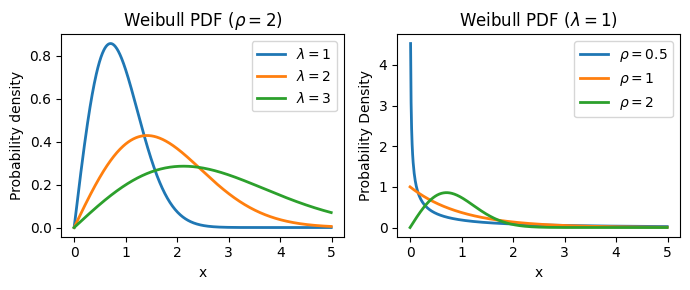

In [46]:
import numpy as np
from scipy.stats import weibull_min

# Create a range of values for x
x = np.arange(0, 5, 0.01)

# Create the 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Left subplot: varying lambda with rho = 2
for scale in [1, 2, 3]:
    pdf = weibull_min.pdf(x, 2, scale=scale)
    axes[0].plot(x, pdf, lw=2, label=fr'$\lambda=${scale}')

axes[0].set_title(r'Weibull PDF ($\rho=2$)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Probability density')
axes[0].legend()

# Right subplot: varying rho with lambda = 1
for rho in [0.5, 1, 2]:
    pdf = weibull_min.pdf(x, rho, scale=1)
    axes[1].plot(x, pdf, lw=2, label=fr'$\rho=${rho}')

axes[1].set_title(r'Weibull PDF ($\lambda=1$)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Probability Density')
axes[1].legend()

plt.tight_layout();

The Weibull distribution provides a parameterized form for the survival function: $S(t)=\exp[-(t / \lambda)^\rho]$, where:
- $S(t)$: the survival function, representing the probability of surviving beyond time $t$.
- $\lambda$ (lambda): the *scale* parameter, which influences the time scale of the survival curve:
  - It has a direct and intuitive interpretation: it represents the time at which 63.2% of the population has experienced the event of interest (e.g., death).
  - A larger $\lambda$ indicates a longer time until 63.2% of the population experiences the event, suggesting a slower event rate overall.
- $\rho$ (rho): the *shape* parameter, which controls the shape of the hazard function and, consequently, the survival curve:
  - It governs the shape of the hazard function and determines whether the hazard rate is increasing, decreasing, or constant over time.
  - $\rho < 1$: the hazard rate decreases over time (*decelerating hazard*). This might be suitable for modeling situations where the risk of the event diminishes as time progresses (e.g., infant mortality).
  - $\rho = 1$: the hazard rate is *constant* over time. This is equivalent to the exponential distribution, often used when the risk of the event remains stable.
  - $\rho > 1$: the hazard rate increases over time (*accelerating hazard*). This could be applicable when the risk of the event escalates with time (e.g., the failure of aging machinery).

The Weibull model also provides explicit expressions for the hazard function and cumulative hazard function:
- Cumulative Hazard Function: $H(t) = (t / \lambda)^ρ$
- Hazard Function: $h(t) = (\rho / \lambda) * (t / \lambda)^{\rho - 1}$

The Weibull model has many advantages:
- Flexibility: can model various hazard shapes (increasing, decreasing, or constant).
- Parametric: provides estimates of parameters ($\lambda$ and $\rho$) that can be interpreted directly.
- Handles covariates: allows for the inclusion of covariates to adjust for their effects on survival.

We can consider opting for the Weibull model in scenarios where we have prior knowledge or evidence hinting at a particular hazard shape - be it increasing, decreasing, or constant. Additionally, it proves valuable when we seek parameters with straightforward interpretations, such as the time by which 63.2% of the population is expected to experience the event. Finally, the Weibull model emerges as a suitable alternative when the proportional hazards assumption, fundamental to the Cox PH model, appears to be violated in the data.

### Application to the prednisolone data

Now, let's apply the Weibull model to our prednisolone dataset. We'll fit separate Weibull models to the placebo and treatment groups, then visually compare their survival functions against the corresponding Kaplan-Meier estimates for a comprehensive understanding of the data.

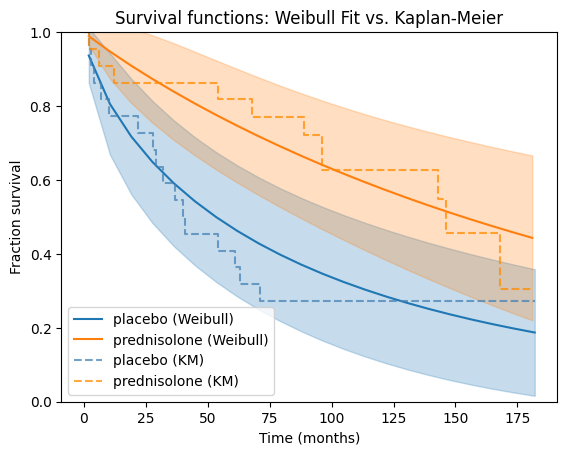

In [47]:
from lifelines import WeibullFitter

# Fit Weibull models for each group
wb_ctrl = WeibullFitter()
wb_pred = WeibullFitter()

wb_ctrl.fit(
    durations=data[~data['PRED']]['T'],
    event_observed=data[~data['PRED']]['E'],
    label='placebo (Weibull)')
wb_pred.fit(
    data[data['PRED']]['T'],
    data[data['PRED']]['E'],
    label='prednisolone (Weibull)')

# Plot survival functions
ax = wb_ctrl.plot_survival_function()
wb_pred.plot_survival_function(ax=ax)

# Overlay Kaplan-Meier curves on the same plot
kmf_ctrl.plot(ax=ax, ci_show=False, color='steelblue', ls='--', alpha=.75)  # Dashed line for KM
kmf_pred.plot(ax=ax, ci_show=False, color='darkorange', ls='--', alpha=.75)

plt.title("Survival functions: Weibull Fit vs. Kaplan-Meier")
plt.xlabel("Time (months)")
plt.ylim((0, 1))
plt.ylabel("Fraction survival");

### Goodness-of-fit

These interpretations are based on the assumption that the Weibull model provides a good fit to the data for both groups. It's always advisable to assess the model fit and consider alternative models if necessary.

The visual comparison with the Kaplan-Meier plots is straightforward and intuitive as we can see how well the Weibull model captures the empirical survival patterns in the data. If the Weibull curves closely follow the Kaplan-Meier curves, it suggests a good fit. Large deviations between the curves indicate potential areas where the Weibull model might not be capturing the underlying survival patterns adequately.

We can leverage the log-likelihood and AIC values provided in the Weibull model summary table to gain some insights into the goodness-of-fit, but with certain considerations and limitations. In general, a higher log-likelihood value indicates a better fit of the model to the data, but the log-likelihood alone doesn't tell if the model is a "good" fit in an absolute sense. It's more useful for relative comparisons between models, e.g., when [testing other parametric models](more-models).

While AIC and visual comparisons of survival curves offer valuable insights into model fit, we can further assess the suitability of the Weibull model using a Quantile-Quantile (QQ) plot. The QQ plot compares the quantiles of the observed data to the quantiles we would expect if the data truly followed a Weibull distribution.

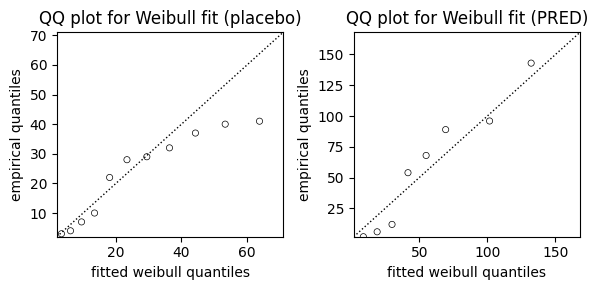

In [48]:
from lifelines.plotting import qq_plot

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# QQ plot for placebo group
qq_plot(wb_ctrl, ax=axes[0])
axes[0].set_title("QQ plot for Weibull fit (placebo)")

# QQ plot for PRED Group
qq_plot(wb_pred, ax=axes[1])
axes[1].set_title("QQ plot for Weibull fit (PRED)")

# Adjust layout and display the plot
plt.tight_layout();

### Parameters estimates

We can print the model summaries to see the estimated parameters and their confidence intervals.

In [49]:
print(s:="Model summary for the prednisone group")
print("-"*len(s))
wb_pred.print_summary(style='ascii')

Model summary for the prednisone group
--------------------------------------
<lifelines.WeibullFitter:"prednisolone (Weibull)", fitted with 22 total observations, 11 right-censored observations>
   number of observations = 22
number of events observed = 11
           log-likelihood = -70.27
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 224.72     79.37           69.16          380.27
rho_      0.95      0.27            0.43            1.48

         cmp to     z      p  -log2(p)
lambda_    1.00  2.82 <0.005      7.70
rho_       1.00 -0.17   0.87      0.21
---
AIC = 144.54



Overall context:
- The table shows the results of fitting a Weibull survival model to your data, specifically for the group that received prednisone.
- We have 22 observations in total, out of which 11 experienced the event of interest (presumably death or some other failure event), while the remaining 11 were right-censored (meaning they didn't experience the event during the observation period).

Model fit statistics:
- **log-likelihood = -70.27**: his is a measure of how well the Weibull model fits the data. Higher values (less negative) indicate a better fit.
- **AIC = 144.54**: *Akaike Information Criterion*, another measure of model fit, penalizing for model complexity. Lower AIC values are generally preferred.

Hypothesis test:
- **hypothesis = lambda_ != 1, rho_ != 1**: the model is testing whether the estimated parameters (lambda and rho) are significantly different from 1. This is a common baseline to check if the Weibull model provides a better fit than the simpler exponential model (where rho = 1).

Parameter estimates:
- **lambda_**
  - **coef = 224.72**: the estimated scale parameter ($\lambda$) is 224.72. This means that 63.2% of the individuals in the prednisone group are expected to experience the event by approximately 224.72 months, or 18.7 years.
  - **se(coef) = 79.37**: the standard error of the lambda estimate, indicating the uncertainty around this estimate.
  - **coef lower 95% = 69.16, coef upper 95% = 380.27**: the 95% confidence interval for the lambda coefficient.
  - **cmp to 1.00, z = 2.82, p <0.005, -log2(p) = 7.70**: these statistics test the null hypothesis that lambda is equal to 1. The very small P value (<0.005) strongly suggests that lambda is significantly different from 1, indicating that the Weibull model is a better fit than the exponential model for this group.
- **rho_**
  - **coef = 0.95**: the estimated shape parameter ($\rho$) is 0.95. This is slightly less than 1, suggesting a hazard rate that decreases slightly over time for the prednisone group.
  - **se(coef) = 0.27**: the standard error of the rho estimate.
  - **coef lower 95% = 0.43, coef upper 95% = 1.48**: the 95% confidence interval for the rho coefficient. Note that this interval includes 1.
  - **cmp to 1.00, z = -0.17, p = 0.87, -log2(p) = 0.21**: these statistics test the null hypothesis that rho is equal to 1. The large P value (0.87) indicates that we don't have strong evidence to reject this null hypothesis. This suggests that the hazard rate might be close to constant, and an exponential model could also be a reasonable fit for this group, although the Weibull model with a slightly decreasing hazard might be slightly better.

In [50]:
print(s := "Model summary for the placebo group")
print("-"*len(s))
wb_ctrl.print_summary(style='ascii')

Model summary for the placebo group
-----------------------------------
<lifelines.WeibullFitter:"placebo (Weibull)", fitted with 22 total observations, 6 right-censored observations>
   number of observations = 22
number of events observed = 16
           log-likelihood = -86.43
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 88.79     30.92           28.20          149.39
rho_     0.72      0.15            0.42            1.02

         cmp to     z      p  -log2(p)
lambda_    1.00  2.84 <0.005      7.79
rho_       1.00 -1.83   0.07      3.90
---
AIC = 176.87



Here in the placebo group, the lambda ($\lambda$) value is significantly lower than that of the prednisone group (88.79 vs. 224.72). This indicates that the median survival time (time at which 63.2% of the population experiences the event) is considerably shorter for the placebo group compared to the prednisone group.

The rho ($\rho$) value for the placebo group is 0.72, which is less than 1. This suggests a decreasing hazard rate over time for the control group. The risk of the event is higher initially but decreases as time progresses. The rho ($\rho$) value for the prednisone group is 0.95, which is close to 1. This suggests a hazard rate that is nearly constant over time for the prednisone group. The risk of the event remains relatively stable throughout the follow-up period.

### Weibull regression

When exploring the influence of one or more continuous variables (covariates) on survival, we turn to the **Accelerated Failure Time (AFT)** model. The AFT model, in the context of Weibull regression, provides a framework to understand how covariates accelerate or decelerate the time to an event, i.e., $Y_i = f(X_i, \beta)$. The core concept of the AFT model can be summarized as: $S_A(t) = S_B(t \times \lambda)$, where:
- $S_A(t)$ and $S_B(t)$ are the survival functions for two individuals or groups with different covariate values. $S_B(t)$ is accelerating (speeding up) or decelerating (slowing down) along $S_A(t)$ by a factor of $\lambda$.
- $\lambda$ (lambda) is the acceleration factor, which depends on the covariates and their coefficients.
  - A $\lambda > 1$ indicates that the event is accelerated (occurs sooner) for the individual or group with those covariate values compared to the baseline.
  - A $\lambda < 1$ indicates that the event is decelerated (occurs later).

In the Weibull AFT model, the acceleration factor $\lambda$ is modeled as: $\lambda(x) = \exp(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)$, where:
- $x_1, x_2, \dots, x_n$  are the covariate values.
- $\beta_0, \beta_1, \dots, \beta_n$ are the coefficients, quantifying the impact of each covariate on the acceleration factor.

Optionally, the shape parameter ρ can also be modeled as a function of covariates: $\rho(y) = \exp(\alpha_0 + \alpha_1 y_1 + \dots + \alpha_n y_n)$, where:
- $y_1, y_2, \dots, y_n$ are additional covariate values (if applicable).
- $\alpha_0, \alpha_1, \dots, \alpha_n$ are the coefficients for these covariates.

The final Weibull survival function with covariates becomes $S(t; x, y) = \exp[-(t / \lambda(x))^{\rho(y)}]$, and the cumulative hazard function $H(t; x, y) = (t / \lambda(x))^{\rho(y)}$.

How do we interpret the Weibull AFT model? A positive $\beta_i$ indicates that an increase in the corresponding covariate $x_i$ is associated with an increase in the acceleration factor $\lambda$, leading to a faster time to the event (decreased survival time). A negative $\beta_i$ indicates the opposite: an increase in $x_i$ is associated with a decrease in $\lambda$, leading to a slower time to the event (increased survival time).

Note that, when there are no covariates, or all covariates are at their reference levels (typically 0 for continuous covariates and the reference category for categorical covariates), the Weibull model reduces to its basic form with parameters $\lambda_0$ and $\rho_0$.

In [51]:
from lifelines import WeibullAFTFitter

# Fit the Weibull AFT model
aft = WeibullAFTFitter()
aft.fit(
    df=data,
    duration_col='T',
    event_col='E',
    # formula='PRED'
)

# Print the model summary
aft.print_summary(decimals=2)

<lifelines.WeibullAFTFitter: fitted with 44 total observations, 17 right-censored observations>
             duration col = 'T'
                event col = 'E'
   number of observations = 44
number of events observed = 27
           log-likelihood = -157.02
         time fit was run = 2024-11-08 09:30:10 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ PRED       1.05      2.87      0.51            0.06            2.05                1.06                7.79
        Intercept  4.48     88.34      0.32            3.86            5.10               47.47              164.38
rho_    Intercept -0.24      0.79      0.17           -0.57            0.09                0.57                1.10

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ PRED         0.00  2.07   0.04      4.70
        Intercept    0.00 14.14 <0.005    148.43
rho_    Intercept    0.00 -1.40   0.16      2.64
---
Concordance = 0.63
AIC = 320.03
log-likelihood ratio test = 4.54 on 1 df
-log2(p) of ll-ratio test = 4.92

The results suggest that the treatment ('PRED') is associated with a significant increase in survival time. The positive coefficient for 'PRED' indicates that individuals in the treatment group (PRED = True) experience a deceleration in the time to the event compared to the control group (PRED = False). In other words, the treatment is associated with a longer survival time. The P value is less than 0.05, indicating that the effect of the treatment on survival time is statistically significant.

The intercept for lambda ($\lambda$) represents the log of the baseline scale parameter ($\lambda_0$) in the Weibull AFT model. To get the actual baseline scale parameter, we need to exponentiate this value: $\lambda_0 = exp(4.48) \approx 88.34$. This means that, in the absence of any effect from the 'PRED' covariate (i.e., when PRED = False, which is often considered the baseline or reference group in this context), 63.2% of the individuals are expected to experience the event by approximately 88.34 months.

Finally, the intercept for rho ($\rho$) represents the log of the baseline shape parameter ($\rho_0$) in the Weibull AFT model. To get the actual baseline shape parameter, we need to exponentiate this value: $\rho_0 = exp(-0.24) \approx 0.79$. This indicates that the baseline hazard function (the hazard function when PRED = False) is decreasing over time. A shape parameter less than 1 implies a decreasing hazard rate, meaning the risk of the event is higher initially but diminishes as time progresses.

### Visualization and prediction with Weibull model

Having established the theoretical foundations of the Weibull AFT model, let's demonstrate how the Weibull AFT model can be leveraged to gain valuable insights into real-world survival data. We can visualize the impact of covariates on survival and make predictions using a more complex dataset, showcasing the model's versatility and power.

This data set is originally from [Rossi et al. (1980)](https://rdrr.io/cran/carData/man/Rossi.html), and is used as an example in [Allison (1995)](https://www.oreilly.com/library/view/survival-analysis-using/9781555442798/). The data pertain to 432 convicts who were released from Maryland state prisons in the 1970s and who were followed up for one year after release. Half the released convicts were assigned at random to an experimental treatment in which they were given financial aid; half did not receive aid.

Note that the visualization and prediction techniques described in this section are applicable to both the Weibull AFT and Cox PH models, allowing us to gain a deeper understanding of the relationships between covariates and survival outcomes, regardless of the specific model.

In [52]:
from lifelines.datasets import load_rossi

rossi = load_rossi()
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


We can use formula to analyze linear models with interaction terms, e.g., $\beta_1 \text{fin} + \beta_2 \text{wexp} + \beta_3 \text{age} +\beta_4 \text{prio} + \beta_5 \text{age}.\text{prio}$, as in the example below. Note that it's also possible to [model the $\rho$ parameter](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#modeling-ancillary-parameters).

In [53]:
aft_rossi = WeibullAFTFitter()
aft_rossi.fit(
    df=rossi,
    duration_col='week',
    event_col='arrest',
    formula="fin + wexp + age * prio"
)

aft_rossi.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
   number of observations = 432
number of events observed = 114
           log-likelihood = -680.563
         time fit was run = 2024-11-08 09:30:10 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ Intercept  4.308    74.261     0.501           3.325           5.290              27.805             198.336
        fin        0.236     1.266     0.137          -0.033           0.505               0.968               1.657
        wexp       0.169     1.184     0.150          -0.125           0.463               0.883               1.589
        age        0.020     1.020     0.022          -0.023           0.063               0.977               1.065
        prio      -0.220     0.802     0.122          -0.460           0.020               0.631               1.020
        age:prio   0.007     1.007     0.005          -0.004           0.018               0.996               1.018
rho_    Intercept  0.341     1.406     0.089           0.167           0.515               1.181               1.674

                   cmp to      z       p  -log2(p)
param   covariate                                 
lambda_ Intercept   0.000  8.594 <0.0005    56.727
        fin         0.000  1.722   0.085     3.556
        wexp        0.000  1.128   0.259     1.947
        age         0.000  0.916   0.359     1.476
        prio        0.000 -1.801   0.072     3.801
        age:prio    0.000  1.282   0.200     2.323
rho_    Intercept   0.000  3.833 <0.0005    12.949
---
Concordance = 0.640
AIC = 1375.126
log-likelihood ratio test = 32.123 on 5 df
-log2(p) of ll-ratio test = 17.441

We can view all covariate estimates and their 95% confidence intervals in a forest plot.

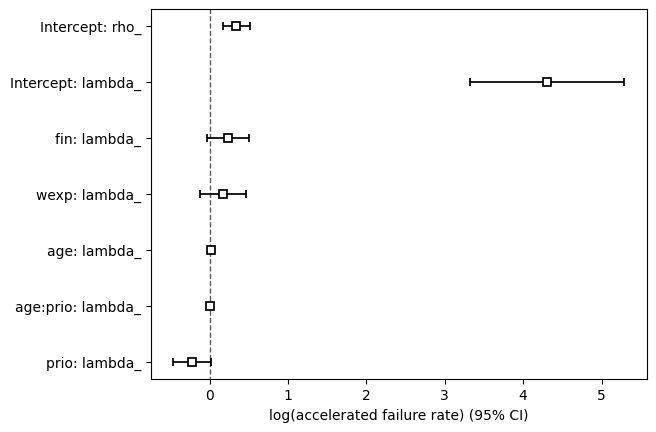

In [54]:
aft_rossi.plot();

We can also observe the influence a variable, e.g., 'prio', in the model by plotting the outcome (i.e. survival) of changing the variable. By comparing the positions and shapes of these curves, we can visually assess how changes in this covariate affect the predicted survival time. In a Weibull AFT model, a negative coefficient for a covariate (like 'prio') indicates that an increase in that covariate is associated with a decrease in the acceleration factor ($\lambda$). This implies that higher values of 'prio' should lead to a slower time to the event (i.e., increased survival time), and we would expect the survival curve to shift to the right.

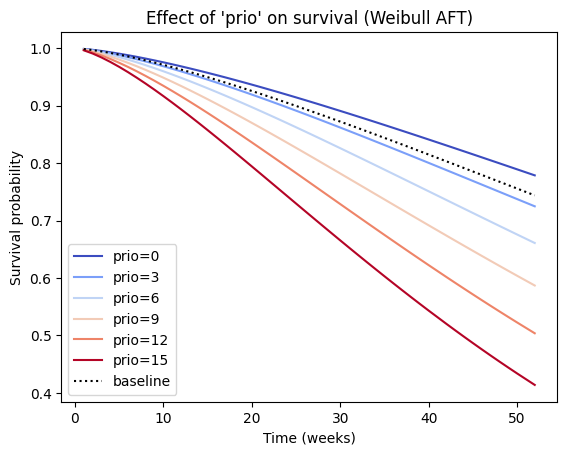

In [55]:
aft_rossi.plot_partial_effects_on_outcome(
    covariates='prio',
    values=range(0, 16, 3),
    cmap='coolwarm'
)

plt.title("Effect of 'prio' on survival (Weibull AFT)")
plt.xlabel('Time (weeks)')
plt.ylabel('Survival probability');

In the current example, we observe that increasing 'prio' shifts the survival curve to the left, which typically indicates a faster time to the event (decreased survival time). This may be due to interaction effects. If the Weibull AFT model includes interaction terms involving 'prio', the interpretation of the main effect of 'prio' becomes more complex, and the effect of 'prio' on survival might depend on the values of other covariates involved in the interaction. In such cases, it's essential to examine the `plot_partial_effects_on_outcome` for different combinations of covariate values to understand the full picture.

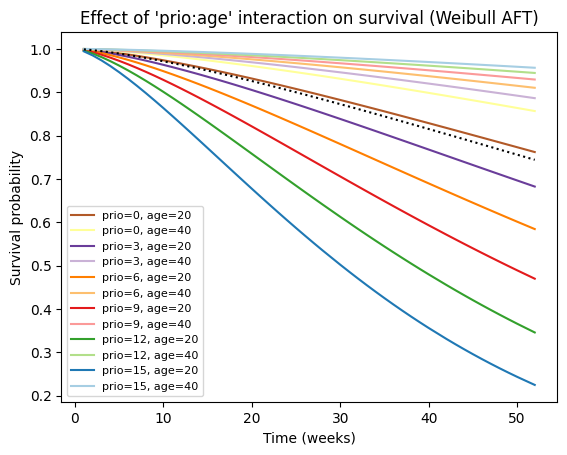

In [56]:
# Create a list of tuples representing combinations of 'prio' and 'age' values
values_grid = [(p, a) for p in range(0, 16, 3) for a in range(20, 41, 20)]

# Plot the partial effects on outcome for the combined covariates
aft_rossi.plot_partial_effects_on_outcome(
    covariates=['prio', 'age'], values=values_grid, cmap='Paired_r')

# Enhance the plot with labels and title
plt.title("Effect of 'prio:age' interaction on survival (Weibull AFT)")
plt.xlabel('Time (weeks)')
plt.ylabel('Survival probability')

plt.legend([f"prio={p}, age={a}" for p, a in values_grid], fontsize=8);

Finally, we can obtain survival predictions for one or more new individuals from the fitted Weibull AFT model.

In [57]:
# Predict median survival time for a specific combination of covariates
# Note: don't feed `predict_median` with a Series but with a true DataFrame!
median_survival = aft_rossi.predict_median(rossi.iloc[[3]])

print("Predicted median survival time:")
median_survival

Predicted median survival time:


3    128.088796
dtype: float64

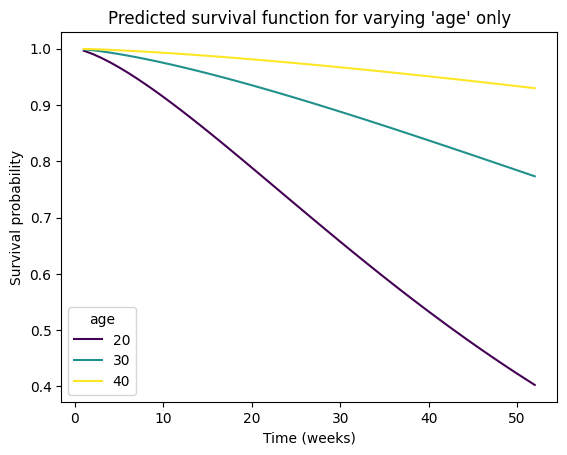

In [58]:
# Predict survival function for a new combination of covariates
# If a numpy array, columns must be in the same order as the training data, i.e.,
# ['fin', 'age', 'race', 'wexp', 'mar', 'paro', 'prio']

new_individual = pd.DataFrame(
    data={
        'fin': [.5, .5, .5],
        'age': [20, 30, 40],
        'race': [1, 1, 1],
        'wexp': [0, 0, 0],
        'mar': [0, 0, 0],
        'paro': [1, 1, 1],
        'prio': [10, 10, 10]
    },
    index=[20, 30, 40],
)

survival_function = aft_rossi.predict_survival_function(new_individual)

# Plot the predicted survival function
survival_function.plot(cmap='viridis')
plt.title(f"Predicted survival function for varying 'age' only")
plt.xlabel('Time (weeks)')
plt.ylabel('Survival probability')
plt.legend(title="age");

(more-models)=
### Alternative parametric models

While the Weibull model offers flexibility in capturing different hazard shapes, it's not the only parametric option available:
- Exponential model: assumes a constant hazard rate over time. It's a special case of the Weibull model with the shape parameter (rho) equal to 1.
- Log-Normal model: assumes that the logarithm of the survival times follows a normal distribution. It can be useful when the hazard rate initially increases and then decreases.
- Log-logistic model: assumes that the logarithm of the odds of survival follows a logistic distribution. It can also model non-monotonic hazard rates.
- Generalized gamma model: a more general model that encompasses the Weibull, exponential, and log-normal models as special cases. It offers additional flexibility but can be more complex to interpret

The Akaike Information Criterion (AIC) is a useful metric for comparing the relative quality of different statistical models fit to the same data. It estimates the relative amount of information lost by a given model and penalizes large number of estimated parameters. Therefore, the less information a model loses, the higher the quality of that model, and the fewer parameters (less complex) a model is, the higher the quality of that model. It balances the model's goodness-of-fit (measured by the log-likelihood) with its complexity (measured by the number of parameters).

In [59]:
import warnings
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, \
    LogLogisticFitter, GeneralizedGammaFitter

warnings.filterwarnings("ignore")

# Instantiate each fitter
wb = WeibullFitter()
exp = ExponentialFitter()
lognorm = LogNormalFitter()
loglogistic = LogLogisticFitter()
gamma = GeneralizedGammaFitter()

# Fit to data and display the AIC
print("AIC values for different models fitting 'PRED' data:\n")
for model in [wb, exp, lognorm, loglogistic, gamma]:
    model.fit(durations=data[data['PRED']]['T'],
              event_observed=data[data['PRED']]['E'])
    print(model.__class__.__name__, '\t', model.AIC_)

AIC values for different models fitting 'PRED' data:

WeibullFitter 	 144.54091487803493
ExponentialFitter 	 142.56870858109932
LogNormalFitter 	 146.80469733430616
LogLogisticFitter 	 145.8274267786253
GeneralizedGammaFitter 	 145.1972001057433


While numerical metrics like AIC provide valuable guidance in model selection, it's always beneficial to complement them with visual inspection. Plotting the fitted survival curves from different parametric models alongside the non-parametric Kaplan-Meier curve offers a quick and intuitive way to gauge the quality of the fit. This visual comparison allows us to see how well each model captures the empirical survival patterns in the data and identify potential areas where a model might be oversimplifying or underfitting the complexities of the survival experience.

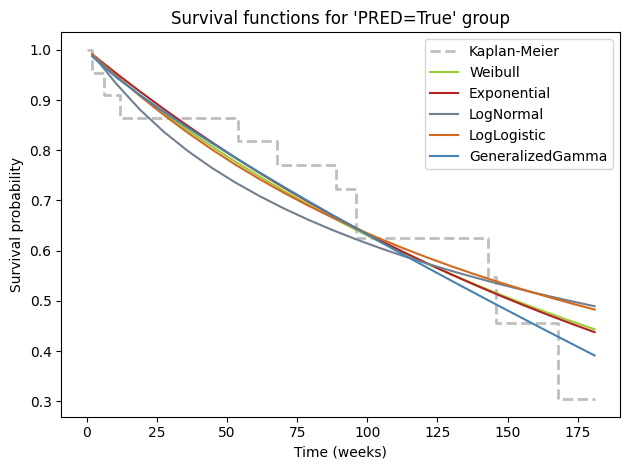

In [ ]:
# Plot for PRED Group
ax = kmf_pred.plot(
    style='--',
    lw=2,
    ci_show=False,
    color='darkgrey',
    alpha=.75,
    label='Kaplan-Meier')

for model, color in zip(
    [wb, exp, lognorm, loglogistic, gamma],
    ['yellowgreen', 'firebrick', 'slategray', 'chocolate', 'steelblue']):
    model.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color,
        label=model.__class__.__name__.removesuffix('Fitter'),
    )

ax.set_title("Survival functions for 'PRED=True' group") # type: ignore
ax.set_xlabel('Time (weeks)') # type: ignore
ax.set_ylabel('Survival probability') # type: ignore
ax.legend() # type: ignore

plt.tight_layout()

Given a set of candidate models for the data, the one with the minimum AIC value is the preferred model. To streamline the process of comparing different parametric models and selecting the best-fitting one based on the AIC criterion, we can leverage the convenient `find_best_parametric_model` function provided by `lifelines`. This function automates the fitting and comparison of multiple parametric models, ensuring consistency in the model selection process.

Let's use this function to identify the best-fitting parametric model for both the 'PRED' and placebo groups in our prednisolone dataset.

In [61]:
from lifelines.utils import find_best_parametric_model

# Find the best parametric model for the placebo group
best_model_ctrl, best_aic_ctrl = find_best_parametric_model(
    event_times=data[~data['PRED']]['T'],
    event_observed=data[~data['PRED']]['E'],
    scoring_method="AIC"
)

# Print the best model and its AIC for the placebo group
print("Best Parametric Model for placebo group:")
print(best_model_ctrl)
print(f"AIC: {best_aic_ctrl:.2f}\n")

# Find the best parametric model for the 'PRED' group
best_model_pred, best_aic_pred = find_best_parametric_model(
    event_times=data[data['PRED']]['T'],
    event_observed=data[data['PRED']]['E'],
    scoring_method="AIC"
)

# Print the best model and its AIC for the 'PRED' group
print("\nBest Parametric Model for 'PRED' group:")
print(best_model_pred)
print(f"AIC: {best_aic_pred:.2f}\n")

Best Parametric Model for placebo group:
<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 22 total observations, 6 right-censored observations>
AIC: 174.54


Best Parametric Model for 'PRED' group:
<lifelines.PiecewiseExponentialFitter:"PiecewiseExponentialFitter: 1 breakpoint", fitted with 22 total observations, 11 right-censored observations>
AIC: 142.35



Our exploration of parametric survival models has revealed the richness and depth of this field. Even within the realm of parametric models, there exists a wide array of options beyond the commonly used Weibull, exponential, and log-normal distributions. The `lifelines` library, with its extensive collection of fitters, provides a powerful toolkit for delving deeper into this fascinating domain.

The emergence of the `PiecewiseExponentialFitter` as the best-fitting model for the 'PRED' group underscores the importance of considering a diverse set of models and letting the data guide the selection process. While we've only scratched the surface in this chapter, the `lifelines` library offers many more advanced models and techniques for those seeking to master the intricacies of survival analysis.

## Conclusion

In this chapter, we embarked on a comprehensive exploration of survival analysis, harnessing the capabilities of the `lifelines` library in Python. We commenced by elucidating the fundamental concepts of survival data and its visual representation through **Kaplan-Meier** curves. The **log-rank test** was then employed to rigorously assess the statistical significance of observed differences in survival between groups. 

We further ventured into the realm of **hazard ratios**, quantifying the relative risks associated with distinct groups, and examined the **Nelson-Aalen estimator**, providing an alternative perspective on the accumulation of risk over time. The chapter subsequently focused on the power of **parametric models**, with a particular emphasis on the **Cox proportional hazards model** and the flexible **Weibull model**. These models allowed us to identify and quantify the impact of **covariates** on survival, enhancing our understanding of the complex interplay between variables and outcomes. The Weibull model's adaptability in accommodating various hazard shapes proved particularly valuable when the proportional hazards assumption of the Cox model was potentially violated.

Throughout the chapter, we emphasized the synergy between visualization and prediction. Techniques like `plot_partial_effects_on_outcome` were employed to graphically illustrate the influence of covariates on survival, while functions such as `predict_median` enabled the extraction of concrete predictions from our models. The critical aspect of model selection was also addressed, utilizing the **AIC criterion** and visual inspections, including **QQ plots**, to guide informed decision-making.

In conclusion, this chapter has equipped readers with the theoretical foundations and practical tools necessary to navigate the complexities of survival analysis. The `lifelines` library, with its extensive suite of functionalities, empowers researchers and practitioners to unveil the intricate dynamics of time-to-event data across diverse fields. We encourage readers to apply these techniques to their own datasets, fostering a deeper understanding of survival phenomena and contributing to the advancement of knowledge in this critical domain.

## Cheat sheet

### Kaplan-Meier

```python
# convert datetimes to durations
from lifelines.utils import datetimes_to_durations
T, E = datetimes_to_durations(
    start_date,  # list/array of datatime values
    end_date,    # list/array of datatime values
    fill_date='2013-10-15')  # value used for NaN

# Fit and plot Kaplan-Meier curves
from lifelines import KaplanMeierFitter
kmf_pred = KaplanMeierFitter(label='prednisolone (KM)')
kmf_pred.fit(
    durations=data.loc[data['PRED'], 'T'],
    event_observed=data.loc[data['PRED'], 'E'],
    #label='prednisolone (KM)'
)

ax = kmf_pred.plot_survival_function(
    show_censors=True,
    lw=2,
    ci_alpha=.1,
    censor_styles=None)  # style as dictionary
# Fit other groups and plot on the same axis

# Extract median survival times
median_survival_pred = kmf_pred.median_survival_time_

# Survival prediction
months=5*12  # i.e., 5-year survival time
kmf_pred.predict(months)
```

### Non-parametric log-rank

```python
from lifelines.statistics import logrank_test
results = logrank_test(
    durations_A=data.loc[data['PRED'], 'T'],
    durations_B=data.loc[~data['PRED'],'T'],
    event_observed_A=data.loc[data['PRED'], 'E'],
    event_observed_B=data.loc[~data['PRED'],'E'],
    alpha=.95)

results.print_summary()
# results.summary, results.p_value, results.test_statistic
```

### Nelson-Aalen cumulative hazard

```python
from lifelines import NelsonAalenFitter

naf_pred = NelsonAalenFitter()
naf_pred.fit(
    data[data['PRED']]['T'],
    event_observed=data[data['PRED']]['E'],
    label='prednisolone')

naf_pred.plot(color='red')
ax = naf_pred.plot(color='red')
```

### Semi-parametric Cox PH

```python
from lifelines import CoxPHFitter

# Fit the CoxPHFitter
cph = CoxPHFitter()
cph.fit(
    df=data,
    duration_col="T",
    event_col="E",
    # formula='PRED'
)

# Print the summary to see the coefficient and its significance
cph.print_summary(decimals=3)

# Assessing the proportional hazards assumption a posteriori
cph.check_assumptions(
    training_df=data,
    p_value_threshold=.05,  # default 0.01
    show_plots=True)

# Visualizing the impact of covariate
cph.plot_partial_effects_on_outcome(
    covariates='PRED',
    values=[False, True],
    plot_baseline=True)
```

### Parametric Weibull

#### Fitting and visualization

```python
from lifelines import WeibullFitter

wb_pred = WeibullFitter()
wb_pred.fit(
    data[data['PRED']]['T'],
    data[data['PRED']]['E'],
    label='prednisolone (Weibull)')

wb_pred.print_summary(style='ascii')

ax = wb_pred.plot_survival_function()
```

#### Goodness-of-fit (QQ plot)

```python
from lifelines.plotting import qq_plot
qq_plot(wb_pred)
```

#### AFT regression

```python
from lifelines import WeibullAFTFitter

aft_rossi = WeibullAFTFitter()

aft_rossi.fit(
    df=rossi,
    duration_col='week',
    event_col='arrest',
    formula="fin + wexp + age * prio",
)

aft_rossi.print_summary(3)

# Plot covariate and 95% CI forest plot
aft_rossi.plot()

# Plot effect of covariate on survival
aft_rossi.plot_partial_effects_on_outcome(
    covariates='prio',
    values=range(0, 16, 3),
    cmap='coolwarm')

# Prediction of median survival
aft_rossi.predict_median(rossi.iloc[[3]])  # don't feed predict_median with a Series but with a true DataFrame!

# Prediction of survival function for a new individual
# Enter values for the new individual(s)
new_individual = pd.DataFrame()  # Could also be an np.array
survival_function = aft_rossi.predict_survival_function(new_individual)
survival_function.plot()
```

### Alternative parametric models

```python
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, \
    LogLogisticFitter, GeneralizedGammaFitter

# Instantiate each fitter
wb = WeibullFitter()
exp = ExponentialFitter()
lognorm = LogNormalFitter()
loglogistic = LogLogisticFitter()
gamma = GeneralizedGammaFitter()

# Fit to data and display the AIC
print("AIC values for different models fitting 'PRED' data:\n")
for model in [wb, exp, lognorm, loglogistic, gamma]:
    model.fit(
        durations=data[data['PRED']]['T'],
        event_observed=data[data['PRED']]['E'])
    print(model.__class__.__name__, '\t', model.AIC_)

# Plot each plot on the KMF curve
ax = kmf_pred.plot()
for model, color in zip(
    [wb, exp, lognorm, loglogistic, gamma],
    ['yellowgreen', 'firebrick', 'slategray', 'chocolate', 'steelblue']):

    model.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color,
        label=model.__class__.__name__.removesuffix('Fitter'))

# Find the best parametric model
from lifelines.utils import find_best_parametric_model

# Find the best parametric model for the 'PRED' group
best_model_pred, best_aic_pred = find_best_parametric_model(
    event_times=data[data['PRED']]['T'],
    event_observed=data[data['PRED']]['E'],
    scoring_method="AIC")
```

## Session information

The output below details all packages and version necessary to reproduce the results in this report.

In [63]:
!python --version
print("-------------")

from importlib.metadata import version

# List of packages we want to check the version
packages = ['numpy', 'pandas', 'lifelines', 'matplotlib', 'seaborn', 'scipy']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    try:
        # Get the version of the package
        package_version = version(package)
        # Append the version to the list
        versions.append(package_version)
    except Exception:  # Use a more general exception for broader compatibility
        versions.append('Not installed')

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.7
-------------
numpy: 1.26.4
pandas: 2.2.2
lifelines: 0.29.0
matplotlib: 3.9.2
seaborn: 0.13.2
scipy: 1.14.1
